In [97]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time

num_cores = 32

%run initMethods.py
%run makeGif.py
%run methods.py

In [98]:
params = { #parameters relevant for the equations
    "Nh":          100000,
    "N0":           10000,
    "R0":              10,
    "M":                1, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":            0.02, #mutation rate
    "v0":               2,
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":               10, #cross-reactivity kernel
    "rho":           5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                  100,
    "dx":                         1,
    "t0":                         0, 
    "tf":                       100,
    "dt":                         1,
    "initial_mean":           [0,0],
    "initial_var":                5,
    "n_step_prior":               5,
    "conv_size":               1000,
    "num_threads":               24,
    "tail_axis":            [1, 1],
}

In [62]:
n = init_guassian_parallel(params["N0"], sim_params)
nh = init_exptail_parrallel(params["Nh"], params, sim_params)
kernel = init_kernel(params, sim_params)

In [63]:
p = coverage_parrallel_convolution(nh, kernel, params, sim_params)


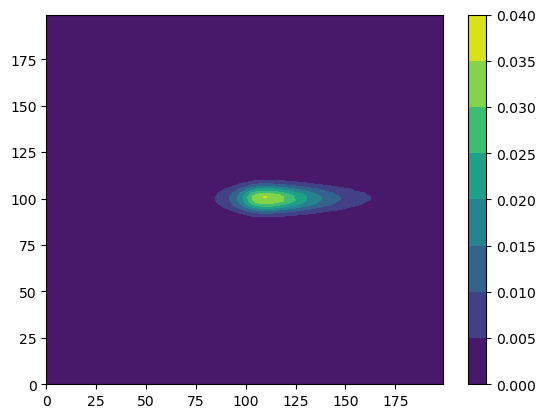

In [36]:
plt.contourf(p)
plt.colorbar()

In [64]:
f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)

1

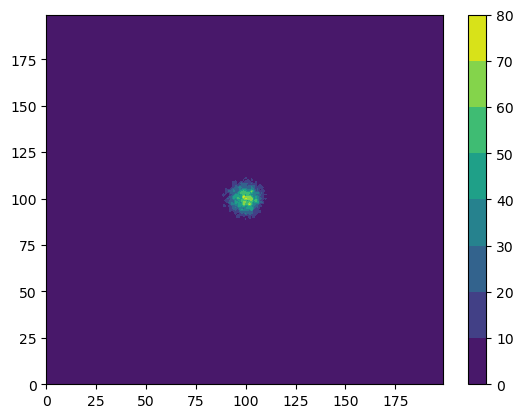

In [60]:
plt.contourf(n)
plt.colorbar()

In [69]:
n_new = virus_growth(n,f, params, sim_params)

In [70]:
np.sum(n)

9721

In [102]:
def growth_calc(n_split, nh_split, params, sim_params):
    if np.sum(n_split) > 0:
        p_split = coverage_convolution(nh_split, kernel, params, sim_params)
        f_split = fitness_spacers(n_split, nh_split, p_split, params, sim_params)
        n_split = virus_growth(n_split, f_split, params, sim_params)
    return n_split

def immunity_calc(nh_split, n_split, params, sim_params):
    
    nh_split = immunity_gain(nh_split, n_split, params, sim_params)
    nh_split = immunity_loss(nh_split, n_split, params, sim_params)
    return nh_split

In [101]:
# R0_sweep = np.exp(np.linspace(0, 1, 10))
R0_sweep = [10]
exit_time = []
f_overtime = []
N_overtime = []
n_frames = []
nh_frames = []
kernel = init_kernel(params, sim_params)

for R0 in R0_sweep:
    params["R0"] = R0
    st0 = time.time()
    n = init_guassian_parallel(params["N0"], sim_params)
    nh = init_exptail_parrallel(params["Nh"], params,sim_params)
    st1 = time.time()

    et0 = time.strftime("%H:%M:%S", time.gmtime(st1 - st0))
    print(f"Reproduction Rate R0: {R0} | init time: {et0}")

    for i in range(100):
        st1 = time.time()
        p = coverage_parrallel_convolution(nh, kernel, params, sim_params)
        st2 = time.time()
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        st3 = time.time()
        f_avg = np.sum(f*n/np.sum(n))
        n = virus_growth(n, f-f_avg, params, sim_params) #update
        st4 = time.time()

        et1 = time.strftime("%H:%M:%S", time.gmtime(st2 - st1))
        et2 = time.strftime("%H:%M:%S", time.gmtime(st3 - st2))
        et3 = time.strftime("%H:%M:%S", time.gmtime(st4 - st3))
        print("Convolution Time:", et1, "| Fitness Spacer Time", et2, "| Virus Growth Time", et3)

        n = mutation_parallel(n, params, sim_params)
        st5 = time.time()
        nh = immunity_update_parallel(nh, n, params, sim_params) #update nh
        st6 = time.time()


        et4 = time.strftime("%H:%M:%S", time.gmtime(st5 - st4))
        et5 = time.strftime("%H:%M:%S", time.gmtime(st6 - st5))
        print("Mutation Parallel:", et4, "| Immunity Update Parallel:", et5, "| Number of Phage:", np.sum(n))

        f_overtime.append(f_avg)
        N_overtime.append(np.sum(n))
        n_frames.append(n)
        nh_frames.append(nh)

        if np.sum(n) >= 10*params["Nh"]:
            # exit_time.append(i)
            break
        


    else:
        exit_time.append(1000)
# plt.imshow(n)
# plt.imshow(nh)

Reproduction Rate R0: 10 | init time: 00:00:00
Convolution Time: 00:00:05 | Fitness Spacer Time 00:00:00 | Virus Growth Time 00:00:00
Mutation Parallel: 00:00:00 | Immunity Update Parallel: 00:00:00 | Number of Phage: 10129
Convolution Time: 00:00:06 | Fitness Spacer Time 00:00:00 | Virus Growth Time 00:00:00
Mutation Parallel: 00:00:00 | Immunity Update Parallel: 00:00:00 | Number of Phage: 9860
Convolution Time: 00:00:06 | Fitness Spacer Time 00:00:00 | Virus Growth Time 00:00:00
Mutation Parallel: 00:00:00 | Immunity Update Parallel: 00:00:00 | Number of Phage: 9967
Convolution Time: 00:00:06 | Fitness Spacer Time 00:00:00 | Virus Growth Time 00:00:00
Mutation Parallel: 00:00:00 | Immunity Update Parallel: 00:00:00 | Number of Phage: 9972
Convolution Time: 00:00:06 | Fitness Spacer Time 00:00:00 | Virus Growth Time 00:00:00
Mutation Parallel: 00:00:00 | Immunity Update Parallel: 00:00:00 | Number of Phage: 9896
Convolution Time: 00:00:06 | Fitness Spacer Time 00:00:00 | Virus Growth

In [82]:
makeGif(nh_frames, "nh")

MovieWriter ffmpeg unavailable; using Pillow instead.


1